# VASP CdTe benchmark performance

This notebook compares the performance of the VASP CdTe benchmark (hybrid DFT, exact exchange) between ARCHER and various configurations on ARCHER2.

Basic information:
  - Uses `vasp_ncl`
  - `NELM = 6`

Performance summary:
- VASP version:
  + Up to 8 nodes: best performance from VASP 6.3.0
  + 16 nodes or more: best performance from VASP 5.4.4.pl2
- Cores per node:
  + Best performance usually from 128 MPI processes per node - all cores occupied
  + At 64 nodes, best performance from 64 MPI processes per node - 64 cores idle per node
- `NCORE`:
  + Up to 8 nodes: best performance with `NCORE = 4` (VASP 6.3.0)
  + 16 nodes or more: best performance with `NCORE = 16` (VASP 5.4.4.pl2)
- `KPAR = 2` is maximum that can be used on standard memory nodes 
- Scales well to 64 nodes
- Using OpenMP threads results in worse performance

We compute performance using the maximum time for a "LOOP" cycle as reported by VASP.

Performance is plotted as LOOP per second (i.e. inverse of LOOP cycle time in seconds).

We have investigated the performance of different versions of VASP and different numerical libraries:

- On ARCHER: Intel Compilers 17, Cray FFTW, Intel MKL 17, Cray MPICH
- On ARCHER2: GCC compilers (v 10.x or 11.x), HPE Cray FFTW 3.3.8.x, HPE Cray MPICH, AOCL or HPE Cray LibSci

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')


In [3]:
from utilities import filemanip, sysinfo
from appanalysis import vasp

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

## Process data

In [5]:

results = ['results-orig/ARCHER',
           'results/ARCHER2_VASP642_LibSci-22.12_OFI',
           'results/ARCHER2_VASP642_LibSci-22.12_UCX',
           'results/ARCHER2_VASP642_MKL-19.5_OFI',
           'results/ARCHER2_VASP642_MKL-19.5_UCX',
           'results/ARCHER2_VASP642_AOCL-4.0_OFI',
           'results/ARCHER2_VASP642_AOCL-4.0_UCX'
          ]
systems = {
    'results-orig/ARCHER': 'ARCHER',
    'results/ARCHER2_VASP642_LibSci-22.12_OFI': 'ARCHER2',
    'results/ARCHER2_VASP642_LibSci-22.12_UCX': 'ARCHER2',
    'results/ARCHER2_VASP642_MKL-19.5_OFI': 'ARCHER2',
    'results/ARCHER2_VASP642_MKL-19.5_UCX': 'ARCHER2',
    'results/ARCHER2_VASP642_AOCL-4.0_OFI': 'ARCHER2',
    'results/ARCHER2_VASP642_AOCL-4.0_UCX': 'ARCHER2'
    }
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perfband_nodes = {}
perfbandcore_nodes = {}
perfbandcore_cores = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../CdTe_Hybrid/' + res
    filelist = filemanip.get_filelist(wdir, 'CdTe_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    vasp_df = pd.DataFrame(vasp.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode'], perftype="max", printfilename=False))
    nodes[res], perf_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=False)
    cores[res], perf_cores[res] = vasp.get_perf_stats(vasp_df, 'max', writestats=False, plot_cores=True)
    nodes[res], perfband_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', perf='PerfBands', writestats=True, plot_cores=False)
    nodes[res], perfbandcore_nodes[res] = vasp.get_perf_stats(vasp_df, 'max', perf='PerfBandsCore', writestats=False, plot_cores=False)
    cores[res], perfbandcore_cores[res] = vasp.get_perf_stats(vasp_df, 'max', perf='PerfBandsCore', writestats=False, plot_cores=True)
    print('\n============================================================')


results-orig/ARCHER
                                                    PerfBands            \
                                                          min    median   
Nodes Processes Threads Cores NCORE NPAR KPAR Bands                       
8     192       1       192   8     12   2    780    0.000645  0.000645   
16    384       1       384   8     24   2    792    0.001236  0.001236   
                              24    8    2    776    0.001048  0.001048   
32    768       1       768   8     48   2    816    0.002191  0.002191   
                              48    8    2    776    0.000840  0.000840   
50    1200      1       1200  8     75   2    825    0.003271  0.003271   
64    1536      1       1536  8     96   2    864    0.003411  0.003411   

                                                                         \
                                                          max      mean   
Nodes Processes Threads Cores NCORE NPAR KPAR Bands                       
8  

## Performance Comparison

This plot compares performance for different systems/configurations with respect to "reserved" cores. Reserved cores is defined as the number of nodes multiplied by the total number of cores per node and represents the amount of resource reserved for the run rather than the number of cores used. This is used to be able to compare performance across different systems even when not all cores on a compute node are used.

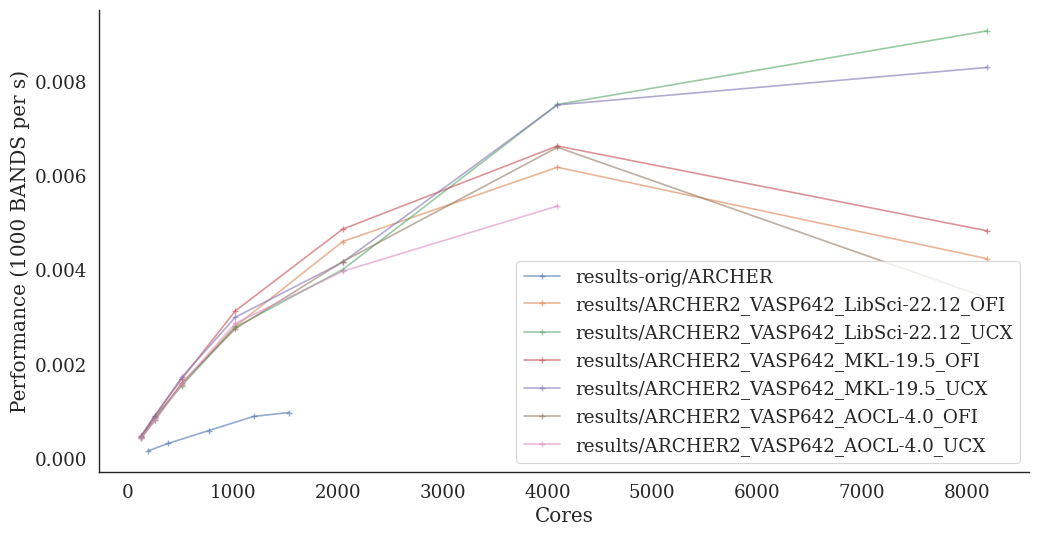

In [6]:
for res in results:
    plt.plot(cores[res], perf_cores[res], '-+', label=names[res], alpha=0.6)
# plt.xlim([0,4096])
plt.xlabel('Cores')
plt.ylabel('Performance (1000 BANDS per s)')
plt.legend(loc='best')
sns.despine()

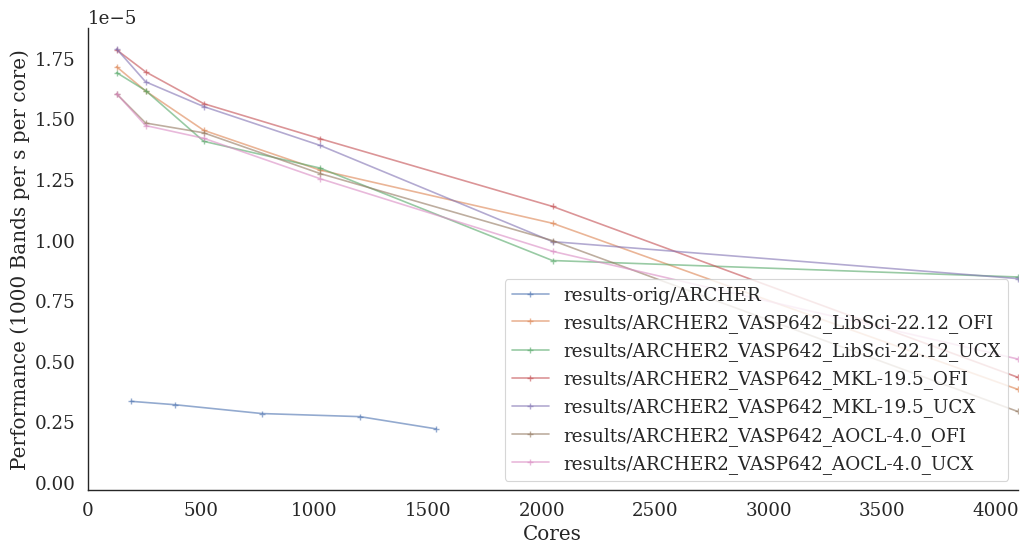

In [7]:
for res in results:
    plt.plot(cores[res], perfbandcore_cores[res], '-+', label=names[res], alpha=0.6)
plt.xlim([0,4096])
plt.xlabel('Cores')
plt.ylabel('Performance (1000 Bands per s per core)')
plt.legend(loc='best')
sns.despine()

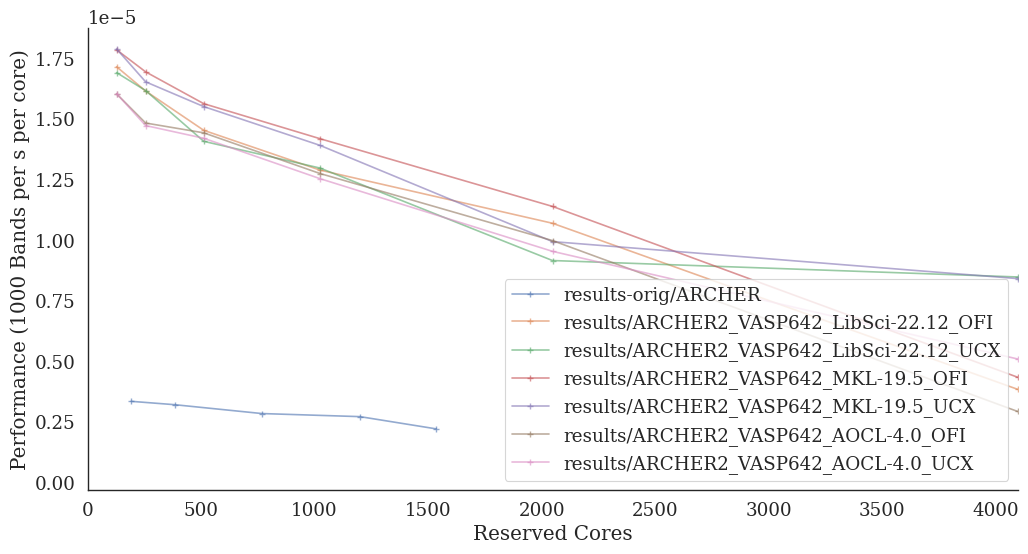

In [8]:
for res in results:
    totcores = [n * cpn[res] for n in nodes[res]]
    plt.plot(totcores, perfbandcore_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlim([0,4096])
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (1000 Bands per s per core)')
plt.legend(loc='best')
sns.despine()